# BERT Tabanlı Modellerin Performans Analizi

Bu notebook'ta farklı BERT tabanlı modellerin (BERT-Base BERT-Large DistilBERT RoBERTa ALBERT) duygu analizi görevindeki performanslarını karşılaştıracağız.

## Amaç
- Farklı BERT modellerinin aynı veri kümesi üzerindeki performansını ölçmek
- Büyük modeller (BERT-Large) ile küçük modeller (BERT-Base DistilBERT) arasındaki performans farklarını incelemek
- Model boyutu eğitim süresi ve performans arasındaki ilişkiyi analiz etmek

In [1]:
import torch
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import (
    BertTokenizerFast, BertForSequenceClassification,
    RobertaTokenizerFast, RobertaForSequenceClassification,
    AlbertTokenizerFast, AlbertForSequenceClassification,
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    Trainer, TrainingArguments
)

c:\Users\osman\OneDrive - Harran Üniversitesi\Belgeler\Movie-Recommendation-System\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Veri Yükleme ve Ön İşleme

In [ ]:
# Veri setini yükle\n,
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

In [16]:
# Veri setini incele
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [17]:
print(f"Eğitim seti boyutu: {train.shape}")
print(f"Test seti boyutu: {test.shape}")

Eğitim seti boyutu: (156060, 4)
Test seti boyutu: (66292, 3)


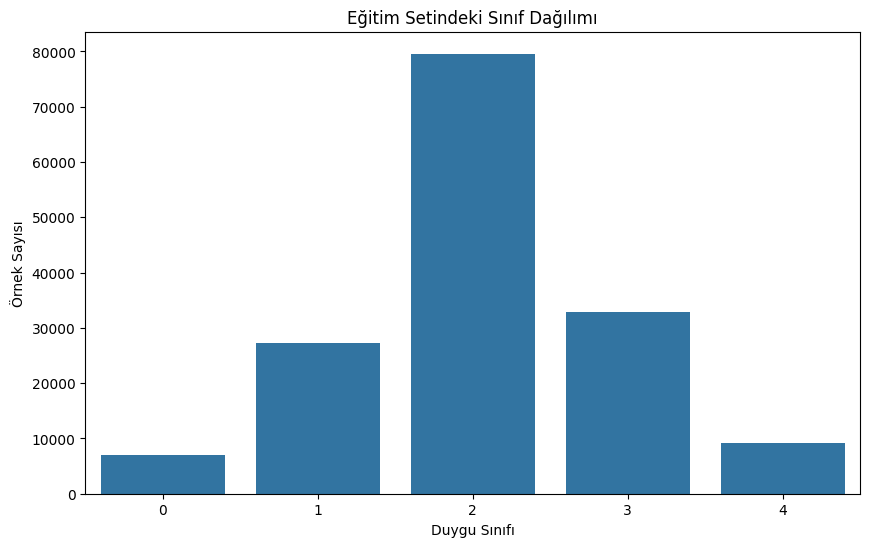

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=train)
plt.title('Eğitim Setindeki Sınıf Dağılımı')
plt.xlabel('Duygu Sınıfı')
plt.ylabel('Örnek Sayısı')
plt.show()

In [19]:
# Tekrarlanan cümleleri kaldır
train = train.drop_duplicates(subset=['SentenceId'], keep='first').reset_index(drop=True)
test = test.drop_duplicates(subset=['SentenceId'], keep='first').reset_index(drop=True)

In [20]:
# Veri setinin boyutunu kontrol et
print(f"Eğitim seti boyutu: {train.shape}")
print(f"Test seti boyutu: {test.shape}")

Eğitim seti boyutu: (8529, 4)
Test seti boyutu: (3310, 3)


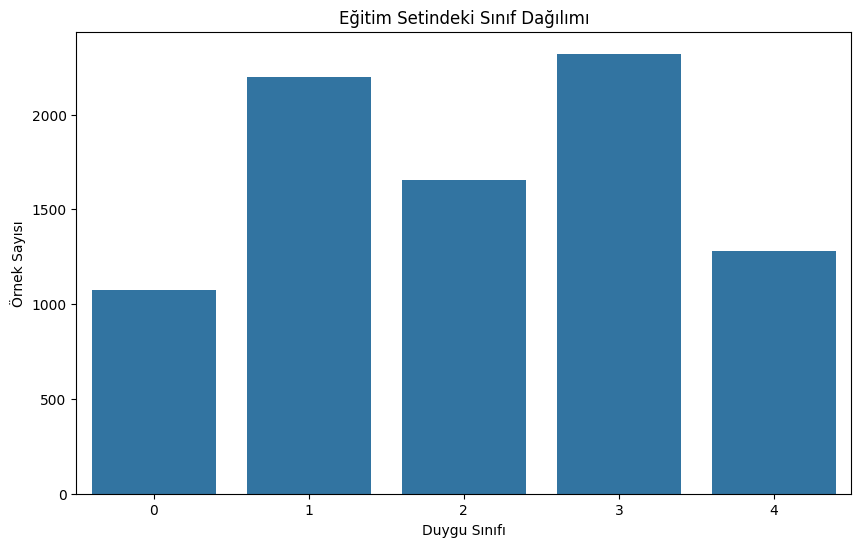

In [21]:
# Sınıf dağılımını kontrol et
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=train)
plt.title('Eğitim Setindeki Sınıf Dağılımı')
plt.xlabel('Duygu Sınıfı')
plt.ylabel('Örnek Sayısı')
plt.show()

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

## 2. Yardımcı Fonksiyonlar

In [ ]:
# Performans metriklerini hesaplayan fonksiyon,
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc, 
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Veri kümesini hazırlayan fonksiyon
def prepare_dataset(df):
    # Eğitim ve doğrulama setlerini ayır
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df['Phrase'].tolist(),
        df['Sentiment'].tolist(),
        test_size=0.2,
        random_state=42,
        stratify=df['Sentiment'] # Dengesizliği korumak için stratify parametresi kullanılır
    )
    return train_texts, val_texts, train_labels, val_labels

In [10]:
# Torch Dataset sınıfı
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
import os
import time
import uuid
import torch

# Model eğitim fonksiyonu
def train_model(model_name, tokenizer, model, train_texts, val_texts, train_labels, val_labels, epochs=3, batch_size=16):
    # CUDA kullanılabilirliğini kontrol et
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Modeli cihaza taşı
    model = model.to(device)
    
    # Create unique log directory to avoid conflicts
    unique_id = str(uuid.uuid4())[:8]
    log_dir = f"./logs/{model_name}_{unique_id}"
    output_dir = f"./results/{model_name}_{unique_id}"
    
    # Create fresh directories
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
    
    # Metinleri tokenize et
    train_encodings = tokenizer(
        train_texts,
        truncation=True,
        padding=True,
        max_length=128
    )
    
    val_encodings = tokenizer(
        val_texts,
        truncation=True,
        padding=True,
        max_length=128
    )
    
    # Dataset oluştur
    train_dataset = SentimentDataset(train_encodings, train_labels)
    val_dataset = SentimentDataset(val_encodings, val_labels)
    
    # Eğitim argümanları
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size*4,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=log_dir,
        logging_steps=50,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        # CUDA ayarları
        no_cuda=not torch.cuda.is_available(),  # CUDA yoksa CPU kullan
        fp16=torch.cuda.is_available(),  # CUDA varsa fp16 hızlandırma kullan
        # Disable TensorBoard to avoid directory issues
        report_to=[]  # This disables TensorBoard and other reporting
    )
    
    # Trainer oluştur
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )
    
    # Eğitim süresini ölç
    start_time = time.time()
    
    # Modeli eğit
    trainer.train()
    
    # Eğitim süresini hesapla
    training_time = time.time() - start_time
    
    # Modeli değerlendir
    eval_results = trainer.evaluate()
    
    # GPU belleğini temizle
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    # Sonuçları döndür
    return {
        'model_name': model_name,
        'training_time': training_time,
        'eval_results': eval_results,
        'model': model,
        'tokenizer': tokenizer
    }

## 3. Veri Hazırlama

In [12]:
# Veri kümesini hazırla
df = train.copy()
train_texts, val_texts, train_labels, val_labels = prepare_dataset(df)

## 4. Model Tanımlamaları

In [13]:
# Model ve tokenizer tanımlamaları
models = [
{
    'name': 'bert-base-uncased',
    'tokenizer': BertTokenizerFast.from_pretrained('bert-base-uncased'),
    'model': BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
},
{
    'name': 'bert-large-uncased',
    'tokenizer': BertTokenizerFast.from_pretrained('bert-large-uncased'),
    'model': BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=5)
},
{
    'name': 'distilbert-base-uncased',
    'tokenizer': DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased'),
    'model': DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
},
{
    'name': 'roberta-base',
    'tokenizer': RobertaTokenizerFast.from_pretrained('roberta-base'),
    'model': RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)
},
{
    'name': 'albert-base-v2',
    'tokenizer': AlbertTokenizerFast.from_pretrained('albert-base-v2'),
    'model': AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=5)
}
]

c:\Users\osman\OneDrive - Harran Üniversitesi\Belgeler\Movie-Recommendation-System\venv\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not ini

## 5. Model Eğitimi ve Değerlendirme

In [ ]:
import os
import shutil
import uuid
import time

# Completely remove the problematic logs directory and recreate it
if os.path.exists('./logs'):
    try:
        shutil.rmtree('./logs')
        print("Removed existing logs directory")
    except Exception as e:
        print(f"Warning: Could not remove logs directory: {e}")
        
# Create fresh directories
os.makedirs('./logs', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./results', exist_ok=True)
os.makedirs('./best_model', exist_ok=True)

print("Created fresh directories")

# Store results
results = []

for model_info in models:
    # After each model training
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print(f"\n{'-'*50}\nEğitiliyor: {model_info['name']}\n{'-'*50}")
    
    # Create unique directories for this model run
    unique_id = str(uuid.uuid4())[:8]
    model_dir = f"./models/{model_info['name']}_{unique_id}"
    result_dir = f"./results/{model_info['name']}_{unique_id}"
    
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(result_dir, exist_ok=True)
    
    print(f"Created unique directories for {model_info['name']}")
    
    # Add a try-except block to handle potential errors during training
    try:
        # Modified train_model call with the unique directories
        result = train_model(
            model_name=model_info['name'],
            tokenizer=model_info['tokenizer'],
            model=model_info['model'],
            train_texts=train_texts,
            val_texts=val_texts,
            train_labels=train_labels,
            val_labels=val_labels,
            epochs=3,
            batch_size=4 if model_info['name'] == 'bert-large-uncased' else 32, 
        )
        
        results.append(result)
        
        print(f"Model: {result['model_name']}")
        print(f"Eğitim Süresi: {result['training_time'] / 60:.2f} dakika")
        print(f"Değerlendirme Sonuçları: {result['eval_results']}")
       
        # Save model and tokenizer
        result['model'].save_pretrained(model_dir)
        result['tokenizer'].save_pretrained(model_dir)
        print(f"Saved model and tokenizer to {model_dir}")
        
        # If this is the best model so far, save it as best_model
        if not results or result['eval_results']['eval_accuracy'] > max([r['eval_results']['eval_accuracy'] for r in results[:-1]], default=0):
            print(f"New best model: {result['model_name']}")
            if os.path.exists('./best_model'):
                shutil.rmtree('./best_model')
            os.makedirs('./best_model', exist_ok=True)
            result['model'].save_pretrained('./best_model')
            result['tokenizer'].save_pretrained('./best_model')
        torch.cuda.empty_cache()
    # After each model training
    
    except Exception as e:
        print(f"Error training model {model_info['name']}: {str(e)}")
        print("Continuing with next model...")
        continue

Created fresh directories

--------------------------------------------------
Eğitiliyor: bert-base-uncased
--------------------------------------------------
Created unique directories for bert-base-uncased
Using device: cuda


  8%|▊         | 51/642 [00:12<02:15,  4.36it/s]

{'loss': 1.6352, 'grad_norm': 2.1488404273986816, 'learning_rate': 5e-06, 'epoch': 0.23}


 16%|█▌        | 101/642 [00:24<02:04,  4.36it/s]

{'loss': 1.5008, 'grad_norm': 7.014379501342773, 'learning_rate': 9.900000000000002e-06, 'epoch': 0.47}


 23%|██▎       | 150/642 [00:36<01:56,  4.22it/s]

{'loss': 1.3049, 'grad_norm': 4.012608051300049, 'learning_rate': 1.48e-05, 'epoch': 0.7}


 31%|███▏      | 201/642 [00:48<01:47,  4.11it/s]

{'loss': 1.2366, 'grad_norm': 5.524808883666992, 'learning_rate': 1.9800000000000004e-05, 'epoch': 0.93}


                                                 
 33%|███▎      | 214/642 [00:55<01:38,  4.35it/s]

{'eval_loss': 1.248148798942566, 'eval_accuracy': 0.458968347010551, 'eval_f1': 0.3819456414102856, 'eval_precision': 0.407211876490277, 'eval_recall': 0.458968347010551, 'eval_runtime': 3.3129, 'eval_samples_per_second': 514.955, 'eval_steps_per_second': 4.226, 'epoch': 1.0}


 39%|███▉      | 250/642 [01:09<02:00,  3.25it/s]

{'loss': 1.1643, 'grad_norm': 5.329949378967285, 'learning_rate': 2.48e-05, 'epoch': 1.17}


 47%|████▋     | 301/642 [01:22<01:25,  3.99it/s]

{'loss': 1.1148, 'grad_norm': 9.388311386108398, 'learning_rate': 2.98e-05, 'epoch': 1.4}


 55%|█████▍    | 350/642 [01:35<01:14,  3.90it/s]

{'loss': 1.1226, 'grad_norm': 7.3920063972473145, 'learning_rate': 3.48e-05, 'epoch': 1.64}


 62%|██████▏   | 401/642 [01:48<01:00,  3.98it/s]

{'loss': 1.1173, 'grad_norm': 7.665891170501709, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.87}


                                                 
 67%|██████▋   | 428/642 [01:58<00:45,  4.67it/s]

{'eval_loss': 1.1321507692337036, 'eval_accuracy': 0.5146541617819461, 'eval_f1': 0.49653586407814926, 'eval_precision': 0.5237502430024972, 'eval_recall': 0.5146541617819461, 'eval_runtime': 3.4626, 'eval_samples_per_second': 492.687, 'eval_steps_per_second': 4.043, 'epoch': 2.0}


 70%|███████   | 450/642 [02:08<00:51,  3.71it/s]

{'loss': 1.01, 'grad_norm': 7.4257917404174805, 'learning_rate': 4.4800000000000005e-05, 'epoch': 2.1}


 78%|███████▊  | 500/642 [02:21<00:37,  3.80it/s]

{'loss': 0.9053, 'grad_norm': 5.684680461883545, 'learning_rate': 4.9800000000000004e-05, 'epoch': 2.34}


 86%|████████▌ | 550/642 [02:34<00:23,  3.88it/s]

{'loss': 0.8725, 'grad_norm': 9.505143165588379, 'learning_rate': 3.3098591549295775e-05, 'epoch': 2.57}


 94%|█████████▎| 601/642 [02:48<00:10,  3.92it/s]

{'loss': 0.8857, 'grad_norm': 11.131575584411621, 'learning_rate': 1.5492957746478872e-05, 'epoch': 2.8}


                                                 
100%|██████████| 642/642 [03:02<00:00,  4.49it/s]

{'eval_loss': 1.1686632633209229, 'eval_accuracy': 0.511137162954279, 'eval_f1': 0.5084188390441348, 'eval_precision': 0.5066529864950664, 'eval_recall': 0.511137162954279, 'eval_runtime': 3.6525, 'eval_samples_per_second': 467.08, 'eval_steps_per_second': 3.833, 'epoch': 3.0}


100%|██████████| 642/642 [03:08<00:00,  3.41it/s]


{'train_runtime': 188.3999, 'train_samples_per_second': 108.647, 'train_steps_per_second': 3.408, 'train_loss': 1.1369850776648596, 'epoch': 3.0}


100%|██████████| 14/14 [00:03<00:00,  4.65it/s]


Model: bert-base-uncased
Eğitim Süresi: 3.22 dakika
Değerlendirme Sonuçları: {'eval_loss': 1.1686632633209229, 'eval_accuracy': 0.511137162954279, 'eval_f1': 0.5084188390441348, 'eval_precision': 0.5066529864950664, 'eval_recall': 0.511137162954279, 'eval_runtime': 3.2914, 'eval_samples_per_second': 518.322, 'eval_steps_per_second': 4.254, 'epoch': 3.0}
Saved model and tokenizer to ./models/bert-base-uncased_aaee7c69
New best model: bert-base-uncased

--------------------------------------------------
Eğitiliyor: bert-large-uncased
--------------------------------------------------
Created unique directories for bert-large-uncased
Using device: cuda


  1%|          | 50/5118 [06:59<11:59:02,  8.51s/it]

{'loss': 1.8671, 'grad_norm': 43.876319885253906, 'learning_rate': 4.5e-06, 'epoch': 0.03}


  2%|▏         | 100/5118 [14:18<10:56:11,  7.85s/it]

{'loss': 1.6304, 'grad_norm': 15.820785522460938, 'learning_rate': 9.5e-06, 'epoch': 0.06}


  3%|▎         | 150/5118 [21:37<11:41:53,  8.48s/it]

{'loss': 1.601, 'grad_norm': 19.848764419555664, 'learning_rate': 1.45e-05, 'epoch': 0.09}


  4%|▍         | 200/5118 [28:42<11:20:27,  8.30s/it]

{'loss': 1.3785, 'grad_norm': 11.220434188842773, 'learning_rate': 1.9500000000000003e-05, 'epoch': 0.12}


  5%|▍         | 250/5118 [35:44<9:46:50,  7.23s/it] 

{'loss': 1.2524, 'grad_norm': 16.447874069213867, 'learning_rate': 2.45e-05, 'epoch': 0.15}


  6%|▌         | 300/5118 [42:52<11:45:34,  8.79s/it]

{'loss': 1.2488, 'grad_norm': 19.42414665222168, 'learning_rate': 2.95e-05, 'epoch': 0.18}


  7%|▋         | 350/5118 [49:54<11:04:57,  8.37s/it]

{'loss': 1.3276, 'grad_norm': 20.717273712158203, 'learning_rate': 3.45e-05, 'epoch': 0.21}


  8%|▊         | 400/5118 [56:57<11:57:28,  9.12s/it]

{'loss': 1.4015, 'grad_norm': 15.5518159866333, 'learning_rate': 3.9500000000000005e-05, 'epoch': 0.23}


  9%|▉         | 450/5118 [1:04:07<11:19:15,  8.73s/it]

{'loss': 1.5426, 'grad_norm': 13.49056339263916, 'learning_rate': 4.4500000000000004e-05, 'epoch': 0.26}


 10%|▉         | 500/5118 [1:11:10<9:31:53,  7.43s/it] 

{'loss': 1.4336, 'grad_norm': 18.60102653503418, 'learning_rate': 4.9500000000000004e-05, 'epoch': 0.29}


 11%|█         | 550/5118 [1:18:12<10:26:28,  8.23s/it]

{'loss': 1.4175, 'grad_norm': 19.344205856323242, 'learning_rate': 4.9512776093546995e-05, 'epoch': 0.32}


 12%|█▏        | 600/5118 [1:25:23<10:07:47,  8.07s/it]

{'loss': 1.5733, 'grad_norm': 14.592170715332031, 'learning_rate': 4.897141619748809e-05, 'epoch': 0.35}


 13%|█▎        | 650/5118 [1:32:26<9:12:36,  7.42s/it] 

{'loss': 1.6247, 'grad_norm': 18.29311752319336, 'learning_rate': 4.843005630142919e-05, 'epoch': 0.38}


 14%|█▎        | 700/5118 [1:39:30<10:30:02,  8.56s/it]

{'loss': 1.5719, 'grad_norm': 10.833806037902832, 'learning_rate': 4.7888696405370294e-05, 'epoch': 0.41}


 15%|█▍        | 750/5118 [1:46:35<10:34:00,  8.71s/it]

{'loss': 1.6218, 'grad_norm': 10.231388092041016, 'learning_rate': 4.734733650931139e-05, 'epoch': 0.44}


 16%|█▌        | 800/5118 [1:53:38<9:16:44,  7.74s/it] 

{'loss': 1.7063, 'grad_norm': 13.562712669372559, 'learning_rate': 4.68059766132525e-05, 'epoch': 0.47}


 17%|█▋        | 850/5118 [2:00:43<10:08:16,  8.55s/it]

{'loss': 1.6004, 'grad_norm': 7.704119682312012, 'learning_rate': 4.626461671719359e-05, 'epoch': 0.5}


 18%|█▊        | 900/5118 [2:07:47<10:15:20,  8.75s/it]

{'loss': 1.623, 'grad_norm': 11.555620193481445, 'learning_rate': 4.5723256821134694e-05, 'epoch': 0.53}


 19%|█▊        | 950/5118 [2:14:48<9:04:55,  7.84s/it] 

{'loss': 1.6017, 'grad_norm': 7.491776943206787, 'learning_rate': 4.5181896925075796e-05, 'epoch': 0.56}


 20%|█▉        | 1000/5118 [2:21:52<8:37:24,  7.54s/it]

{'loss': 1.6458, 'grad_norm': 11.987008094787598, 'learning_rate': 4.464053702901689e-05, 'epoch': 0.59}


 21%|██        | 1050/5118 [2:29:01<9:57:08,  8.81s/it] 

{'loss': 1.6185, 'grad_norm': 9.864466667175293, 'learning_rate': 4.409917713295799e-05, 'epoch': 0.62}


 21%|██▏       | 1100/5118 [2:36:04<9:09:43,  8.21s/it] 

{'loss': 1.5814, 'grad_norm': 19.54568862915039, 'learning_rate': 4.355781723689909e-05, 'epoch': 0.64}


 22%|██▏       | 1150/5118 [2:43:08<9:15:59,  8.41s/it] 

{'loss': 1.6026, 'grad_norm': 10.004101753234863, 'learning_rate': 4.3016457340840196e-05, 'epoch': 0.67}


 23%|██▎       | 1200/5118 [2:50:18<9:26:04,  8.67s/it] 

{'loss': 1.6305, 'grad_norm': 15.716716766357422, 'learning_rate': 4.247509744478129e-05, 'epoch': 0.7}


 24%|██▍       | 1250/5118 [2:57:19<8:18:25,  7.73s/it] 

{'loss': 1.5975, 'grad_norm': 11.410112380981445, 'learning_rate': 4.193373754872239e-05, 'epoch': 0.73}


 25%|██▌       | 1300/5118 [3:04:22<8:49:55,  8.33s/it] 

{'loss': 1.5679, 'grad_norm': 14.61095905303955, 'learning_rate': 4.1392377652663495e-05, 'epoch': 0.76}


 26%|██▋       | 1350/5118 [3:11:28<9:04:20,  8.67s/it] 

{'loss': 1.553, 'grad_norm': 16.722047805786133, 'learning_rate': 4.085101775660459e-05, 'epoch': 0.79}


 27%|██▋       | 1400/5118 [3:18:28<8:19:42,  8.06s/it] 

{'loss': 1.5923, 'grad_norm': 7.722741603851318, 'learning_rate': 4.030965786054569e-05, 'epoch': 0.82}


 28%|██▊       | 1450/5118 [3:25:38<8:48:30,  8.65s/it] 

{'loss': 1.5691, 'grad_norm': 24.61826515197754, 'learning_rate': 3.976829796448679e-05, 'epoch': 0.85}


 29%|██▉       | 1500/5118 [3:32:43<7:31:16,  7.48s/it] 

{'loss': 1.6127, 'grad_norm': 23.66510009765625, 'learning_rate': 3.9226938068427895e-05, 'epoch': 0.88}


 30%|███       | 1550/5118 [3:39:44<7:10:05,  7.23s/it] 

{'loss': 1.6161, 'grad_norm': 16.923805236816406, 'learning_rate': 3.868557817236899e-05, 'epoch': 0.91}


 31%|███▏      | 1600/5118 [3:46:48<7:34:08,  7.75s/it] 

{'loss': 1.6122, 'grad_norm': 8.409173965454102, 'learning_rate': 3.81442182763101e-05, 'epoch': 0.94}


 32%|███▏      | 1650/5118 [3:53:53<8:18:36,  8.63s/it] 

{'loss': 1.6028, 'grad_norm': 13.554037094116211, 'learning_rate': 3.760285838025119e-05, 'epoch': 0.97}


 33%|███▎      | 1700/5118 [4:00:53<7:41:01,  8.09s/it] 

{'loss': 1.6148, 'grad_norm': 22.505512237548828, 'learning_rate': 3.7061498484192295e-05, 'epoch': 1.0}


 33%|███▎      | 1706/5118 [4:01:40<8:47:21,  9.27s/it]c:\Users\osman\OneDrive - Harran Üniversitesi\Belgeler\Movie-Recommendation-System\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

 33%|███▎      | 1706/5118 [4:01:59<8:47:21,  9.27s/it]

{'eval_loss': 1.5826849937438965, 'eval_accuracy': 0.25791324736225085, 'eval_f1': 0.1057612570730572, 'eval_precision': 0.06651924316494161, 'eval_recall': 0.25791324736225085, 'eval_runtime': 18.3495, 'eval_samples_per_second': 92.972, 'eval_steps_per_second': 5.831, 'epoch': 1.0}


 34%|███▍      | 1750/5118 [4:08:47<7:54:24,  8.45s/it] 

{'loss': 1.6203, 'grad_norm': 19.33455467224121, 'learning_rate': 3.652013858813339e-05, 'epoch': 1.03}


 35%|███▌      | 1800/5118 [4:15:43<7:31:10,  8.16s/it]

{'loss': 1.5865, 'grad_norm': 16.684246063232422, 'learning_rate': 3.597877869207449e-05, 'epoch': 1.06}


 36%|███▌      | 1850/5118 [4:22:43<7:00:38,  7.72s/it]

{'loss': 1.5656, 'grad_norm': 14.690391540527344, 'learning_rate': 3.5437418796015594e-05, 'epoch': 1.08}


 37%|███▋      | 1900/5118 [4:29:28<5:42:49,  6.39s/it]

{'loss': 1.6128, 'grad_norm': 7.896274089813232, 'learning_rate': 3.489605889995669e-05, 'epoch': 1.11}


 38%|███▊      | 1950/5118 [4:36:10<7:03:15,  8.02s/it]

{'loss': 1.6008, 'grad_norm': 16.57966423034668, 'learning_rate': 3.43546990038978e-05, 'epoch': 1.14}


 39%|███▉      | 2000/5118 [4:42:51<6:16:13,  7.24s/it]

{'loss': 1.6018, 'grad_norm': 20.812488555908203, 'learning_rate': 3.381333910783889e-05, 'epoch': 1.17}


 40%|████      | 2050/5118 [4:49:32<6:22:09,  7.47s/it]

{'loss': 1.5813, 'grad_norm': 12.117691993713379, 'learning_rate': 3.3271979211779994e-05, 'epoch': 1.2}


 41%|████      | 2100/5118 [4:56:18<6:19:13,  7.54s/it]

{'loss': 1.6131, 'grad_norm': 7.990252494812012, 'learning_rate': 3.2730619315721096e-05, 'epoch': 1.23}


 42%|████▏     | 2150/5118 [5:03:02<6:53:19,  8.36s/it]

{'loss': 1.5726, 'grad_norm': 16.4155330657959, 'learning_rate': 3.218925941966219e-05, 'epoch': 1.26}


 43%|████▎     | 2200/5118 [5:09:43<6:22:01,  7.86s/it]

{'loss': 1.6108, 'grad_norm': 16.281557083129883, 'learning_rate': 3.164789952360329e-05, 'epoch': 1.29}


 44%|████▍     | 2250/5118 [5:16:24<5:29:36,  6.90s/it]

{'loss': 1.6003, 'grad_norm': 11.38588809967041, 'learning_rate': 3.1106539627544394e-05, 'epoch': 1.32}


 45%|████▍     | 2300/5118 [5:23:13<6:17:23,  8.04s/it]

{'loss': 1.5979, 'grad_norm': 16.26024627685547, 'learning_rate': 3.0565179731485496e-05, 'epoch': 1.35}


 46%|████▌     | 2350/5118 [5:29:58<6:09:39,  8.01s/it]

{'loss': 1.6298, 'grad_norm': 14.265623092651367, 'learning_rate': 3.002381983542659e-05, 'epoch': 1.38}


 47%|████▋     | 2400/5118 [5:36:40<6:07:36,  8.12s/it]

{'loss': 1.6164, 'grad_norm': 14.684432983398438, 'learning_rate': 2.948245993936769e-05, 'epoch': 1.41}


 48%|████▊     | 2450/5118 [5:43:26<6:16:03,  8.46s/it]

{'loss': 1.596, 'grad_norm': 14.11247730255127, 'learning_rate': 2.8941100043308794e-05, 'epoch': 1.44}


 49%|████▉     | 2500/5118 [5:50:08<5:31:17,  7.59s/it]

{'loss': 1.584, 'grad_norm': 13.783160209655762, 'learning_rate': 2.8399740147249893e-05, 'epoch': 1.47}


 50%|████▉     | 2550/5118 [5:56:52<5:24:10,  7.57s/it]

{'loss': 1.6001, 'grad_norm': 16.188390731811523, 'learning_rate': 2.785838025119099e-05, 'epoch': 1.49}


 51%|█████     | 2600/5118 [6:03:37<5:44:37,  8.21s/it]

{'loss': 1.6404, 'grad_norm': 14.913002014160156, 'learning_rate': 2.7317020355132096e-05, 'epoch': 1.52}


 52%|█████▏    | 2650/5118 [6:10:18<6:03:22,  8.83s/it]

{'loss': 1.609, 'grad_norm': 7.016654014587402, 'learning_rate': 2.6775660459073195e-05, 'epoch': 1.55}


 53%|█████▎    | 2700/5118 [6:16:57<5:10:23,  7.70s/it]

{'loss': 1.5944, 'grad_norm': 15.866144180297852, 'learning_rate': 2.623430056301429e-05, 'epoch': 1.58}


 54%|█████▎    | 2750/5118 [6:23:41<5:15:52,  8.00s/it]

{'loss': 1.6136, 'grad_norm': 11.336359024047852, 'learning_rate': 2.5692940666955395e-05, 'epoch': 1.61}


 55%|█████▍    | 2800/5118 [6:30:26<4:48:31,  7.47s/it]

{'loss': 1.588, 'grad_norm': 19.564945220947266, 'learning_rate': 2.5151580770896493e-05, 'epoch': 1.64}


 56%|█████▌    | 2850/5118 [6:37:11<5:05:06,  8.07s/it]

{'loss': 1.624, 'grad_norm': 10.656569480895996, 'learning_rate': 2.4610220874837595e-05, 'epoch': 1.67}


 57%|█████▋    | 2900/5118 [6:43:43<4:24:46,  7.16s/it]

{'loss': 1.5843, 'grad_norm': 6.911519527435303, 'learning_rate': 2.4068860978778693e-05, 'epoch': 1.7}


 58%|█████▊    | 2950/5118 [6:50:15<4:13:50,  7.03s/it]

{'loss': 1.585, 'grad_norm': 8.52484130859375, 'learning_rate': 2.3527501082719795e-05, 'epoch': 1.73}


 59%|█████▊    | 3000/5118 [6:57:11<4:48:19,  8.17s/it]

{'loss': 1.5966, 'grad_norm': 15.109465599060059, 'learning_rate': 2.2986141186660893e-05, 'epoch': 1.76}


 60%|█████▉    | 3050/5118 [7:04:21<6:17:59, 10.97s/it]

{'loss': 1.5881, 'grad_norm': 13.276422500610352, 'learning_rate': 2.2444781290601992e-05, 'epoch': 1.79}


 61%|██████    | 3100/5118 [7:11:28<4:48:43,  8.58s/it]

{'loss': 1.5684, 'grad_norm': 14.216737747192383, 'learning_rate': 2.1903421394543093e-05, 'epoch': 1.82}


 62%|██████▏   | 3150/5118 [7:18:29<5:07:06,  9.36s/it]

{'loss': 1.5823, 'grad_norm': 15.943893432617188, 'learning_rate': 2.1362061498484192e-05, 'epoch': 1.85}


 63%|██████▎   | 3200/5118 [7:25:41<5:48:19, 10.90s/it]

{'loss': 1.5335, 'grad_norm': 22.27817726135254, 'learning_rate': 2.0820701602425294e-05, 'epoch': 1.88}


 64%|██████▎   | 3250/5118 [7:32:47<4:11:42,  8.08s/it]

{'loss': 1.5514, 'grad_norm': 13.885841369628906, 'learning_rate': 2.0279341706366392e-05, 'epoch': 1.91}


 64%|██████▍   | 3300/5118 [7:39:47<3:31:34,  6.98s/it]

{'loss': 1.6234, 'grad_norm': 15.869318962097168, 'learning_rate': 1.9737981810307494e-05, 'epoch': 1.93}


 65%|██████▌   | 3350/5118 [7:46:51<4:12:08,  8.56s/it]

{'loss': 1.5804, 'grad_norm': 12.673933029174805, 'learning_rate': 1.9196621914248596e-05, 'epoch': 1.96}


 66%|██████▋   | 3400/5118 [7:53:55<3:28:19,  7.28s/it]

{'loss': 1.5748, 'grad_norm': 22.08446502685547, 'learning_rate': 1.8655262018189694e-05, 'epoch': 1.99}


 67%|██████▋   | 3412/5118 [7:55:27<3:33:51,  7.52s/it]c:\Users\osman\OneDrive - Harran Üniversitesi\Belgeler\Movie-Recommendation-System\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

 67%|██████▋   | 3412/5118 [7:55:49<3:33:51,  7.52s/it]

{'eval_loss': 1.5713062286376953, 'eval_accuracy': 0.2719812426729191, 'eval_f1': 0.11631271576058476, 'eval_precision': 0.07397379636590531, 'eval_recall': 0.2719812426729191, 'eval_runtime': 21.8392, 'eval_samples_per_second': 78.116, 'eval_steps_per_second': 4.899, 'epoch': 2.0}


 67%|██████▋   | 3450/5118 [8:02:15<5:09:46, 11.14s/it] 

{'loss': 1.6042, 'grad_norm': 11.150880813598633, 'learning_rate': 1.8113902122130792e-05, 'epoch': 2.02}


 68%|██████▊   | 3500/5118 [8:09:32<3:37:59,  8.08s/it]

{'loss': 1.5808, 'grad_norm': 16.37531280517578, 'learning_rate': 1.7572542226071894e-05, 'epoch': 2.05}


 69%|██████▉   | 3550/5118 [8:16:50<3:31:06,  8.08s/it]

{'loss': 1.5971, 'grad_norm': 8.861767768859863, 'learning_rate': 1.7031182330012992e-05, 'epoch': 2.08}


 70%|███████   | 3600/5118 [8:24:08<3:33:07,  8.42s/it]

{'loss': 1.5423, 'grad_norm': 14.035526275634766, 'learning_rate': 1.6489822433954094e-05, 'epoch': 2.11}


 71%|███████▏  | 3650/5118 [8:31:11<3:09:10,  7.73s/it]

{'loss': 1.6101, 'grad_norm': 21.748125076293945, 'learning_rate': 1.5948462537895192e-05, 'epoch': 2.14}


 72%|███████▏  | 3700/5118 [8:38:14<3:24:26,  8.65s/it]

{'loss': 1.5993, 'grad_norm': 17.015979766845703, 'learning_rate': 1.5407102641836294e-05, 'epoch': 2.17}


 73%|███████▎  | 3750/5118 [8:45:17<3:01:44,  7.97s/it]

{'loss': 1.6229, 'grad_norm': 10.554559707641602, 'learning_rate': 1.4865742745777394e-05, 'epoch': 2.2}


 74%|███████▍  | 3800/5118 [8:52:19<2:57:12,  8.07s/it]

{'loss': 1.5947, 'grad_norm': 18.019948959350586, 'learning_rate': 1.4324382849718493e-05, 'epoch': 2.23}


 75%|███████▌  | 3850/5118 [8:59:25<3:03:27,  8.68s/it]

{'loss': 1.6105, 'grad_norm': 27.111183166503906, 'learning_rate': 1.3783022953659594e-05, 'epoch': 2.26}


 76%|███████▌  | 3900/5118 [9:06:26<3:33:07, 10.50s/it]

{'loss': 1.5973, 'grad_norm': 16.924062728881836, 'learning_rate': 1.3241663057600693e-05, 'epoch': 2.29}


 77%|███████▋  | 3950/5118 [9:13:26<2:51:02,  8.79s/it]

{'loss': 1.5416, 'grad_norm': 18.15256690979004, 'learning_rate': 1.2700303161541793e-05, 'epoch': 2.32}


 78%|███████▊  | 4000/5118 [9:20:32<3:31:07, 11.33s/it]

{'loss': 1.6098, 'grad_norm': 17.354707717895508, 'learning_rate': 1.2158943265482893e-05, 'epoch': 2.34}


 79%|███████▉  | 4050/5118 [9:27:39<2:28:36,  8.35s/it]

{'loss': 1.5634, 'grad_norm': 14.128204345703125, 'learning_rate': 1.1617583369423995e-05, 'epoch': 2.37}


 80%|████████  | 4100/5118 [9:34:40<2:14:46,  7.94s/it]

{'loss': 1.5267, 'grad_norm': 18.58829116821289, 'learning_rate': 1.1076223473365093e-05, 'epoch': 2.4}


 81%|████████  | 4150/5118 [9:41:47<2:13:27,  8.27s/it]

{'loss': 1.581, 'grad_norm': 13.562108993530273, 'learning_rate': 1.0534863577306193e-05, 'epoch': 2.43}


 82%|████████▏ | 4200/5118 [9:48:52<2:13:35,  8.73s/it]

{'loss': 1.6212, 'grad_norm': 9.5494966506958, 'learning_rate': 9.993503681247293e-06, 'epoch': 2.46}


 83%|████████▎ | 4250/5118 [9:55:51<1:53:54,  7.87s/it]

{'loss': 1.5747, 'grad_norm': 8.705863952636719, 'learning_rate': 9.452143785188395e-06, 'epoch': 2.49}


 84%|████████▍ | 4300/5118 [10:03:07<1:39:11,  7.28s/it]

{'loss': 1.5846, 'grad_norm': 11.794296264648438, 'learning_rate': 8.910783889129493e-06, 'epoch': 2.52}


 85%|████████▍ | 4350/5118 [10:10:08<1:48:16,  8.46s/it]

{'loss': 1.6065, 'grad_norm': 6.717281818389893, 'learning_rate': 8.369423993070593e-06, 'epoch': 2.55}


 86%|████████▌ | 4400/5118 [10:17:06<1:36:34,  8.07s/it]

{'loss': 1.5907, 'grad_norm': 12.381693840026855, 'learning_rate': 7.828064097011693e-06, 'epoch': 2.58}


 87%|████████▋ | 4450/5118 [10:24:12<1:27:46,  7.88s/it]

{'loss': 1.6408, 'grad_norm': 16.847736358642578, 'learning_rate': 7.286704200952794e-06, 'epoch': 2.61}


 88%|████████▊ | 4500/5118 [10:31:16<1:22:59,  8.06s/it]

{'loss': 1.585, 'grad_norm': 10.561643600463867, 'learning_rate': 6.7453443048938944e-06, 'epoch': 2.64}


 89%|████████▉ | 4550/5118 [10:38:17<1:10:10,  7.41s/it]

{'loss': 1.5633, 'grad_norm': 17.7785587310791, 'learning_rate': 6.203984408834994e-06, 'epoch': 2.67}


 90%|████████▉ | 4600/5118 [10:45:21<1:12:25,  8.39s/it]

{'loss': 1.6016, 'grad_norm': 8.304028511047363, 'learning_rate': 5.662624512776094e-06, 'epoch': 2.7}


 91%|█████████ | 4650/5118 [10:52:23<1:05:48,  8.44s/it]

{'loss': 1.5954, 'grad_norm': 11.773849487304688, 'learning_rate': 5.121264616717194e-06, 'epoch': 2.73}


 92%|█████████▏| 4700/5118 [10:59:24<1:11:12, 10.22s/it]

{'loss': 1.5685, 'grad_norm': 12.069730758666992, 'learning_rate': 4.579904720658294e-06, 'epoch': 2.75}


 93%|█████████▎| 4750/5118 [11:06:29<1:06:45, 10.88s/it]

{'loss': 1.5596, 'grad_norm': 19.098161697387695, 'learning_rate': 4.038544824599394e-06, 'epoch': 2.78}


 94%|█████████▍| 4800/5118 [11:13:32<44:22,  8.37s/it]  

{'loss': 1.5849, 'grad_norm': 14.097557067871094, 'learning_rate': 3.4971849285404935e-06, 'epoch': 2.81}


 95%|█████████▍| 4850/5118 [11:20:32<37:41,  8.44s/it]

{'loss': 1.5373, 'grad_norm': 15.457828521728516, 'learning_rate': 2.955825032481594e-06, 'epoch': 2.84}


 96%|█████████▌| 4900/5118 [11:27:39<35:58,  9.90s/it]

{'loss': 1.5812, 'grad_norm': 11.9297456741333, 'learning_rate': 2.4144651364226937e-06, 'epoch': 2.87}


 97%|█████████▋| 4950/5118 [11:34:44<22:03,  7.88s/it]

{'loss': 1.625, 'grad_norm': 7.3708977699279785, 'learning_rate': 1.8731052403637937e-06, 'epoch': 2.9}


 98%|█████████▊| 5000/5118 [11:41:41<15:27,  7.86s/it]

{'loss': 1.5967, 'grad_norm': 18.255882263183594, 'learning_rate': 1.331745344304894e-06, 'epoch': 2.93}


 99%|█████████▊| 5050/5118 [11:48:44<08:49,  7.79s/it]

{'loss': 1.6101, 'grad_norm': 13.68862247467041, 'learning_rate': 7.903854482459941e-07, 'epoch': 2.96}


100%|█████████▉| 5100/5118 [11:55:45<03:14, 10.81s/it]

{'loss': 1.5573, 'grad_norm': 14.52187728881836, 'learning_rate': 2.49025552187094e-07, 'epoch': 2.99}


100%|██████████| 5118/5118 [11:58:09<00:00,  8.27s/it]c:\Users\osman\OneDrive - Harran Üniversitesi\Belgeler\Movie-Recommendation-System\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

100%|██████████| 5118/5118 [11:58:31<00:00,  8.27s/it]

{'eval_loss': 1.5681509971618652, 'eval_accuracy': 0.2719812426729191, 'eval_f1': 0.11631271576058476, 'eval_precision': 0.07397379636590531, 'eval_recall': 0.2719812426729191, 'eval_runtime': 22.1554, 'eval_samples_per_second': 77.002, 'eval_steps_per_second': 4.83, 'epoch': 3.0}


100%|██████████| 5118/5118 [11:59:28<00:00,  8.43s/it]


{'train_runtime': 43168.8067, 'train_samples_per_second': 0.474, 'train_steps_per_second': 0.119, 'train_loss': 1.58092484468592, 'epoch': 3.0}


 99%|█████████▉| 106/107 [00:11<00:00,  7.73it/s]c:\Users\osman\OneDrive - Harran Üniversitesi\Belgeler\Movie-Recommendation-System\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
100%|██████████| 107/107 [00:12<00:00,  8.88it/s]


Model: bert-large-uncased
Eğitim Süresi: 719.52 dakika
Değerlendirme Sonuçları: {'eval_loss': 1.5713062286376953, 'eval_accuracy': 0.2719812426729191, 'eval_f1': 0.11631271576058476, 'eval_precision': 0.07397379636590531, 'eval_recall': 0.2719812426729191, 'eval_runtime': 12.632, 'eval_samples_per_second': 135.054, 'eval_steps_per_second': 8.471, 'epoch': 3.0}
Saved model and tokenizer to ./models/bert-large-uncased_c9d06f54

--------------------------------------------------
Eğitiliyor: distilbert-base-uncased
--------------------------------------------------
Created unique directories for distilbert-base-uncased
Using device: cuda


  8%|▊         | 51/642 [00:07<01:26,  6.82it/s]

{'loss': 1.5993, 'grad_norm': 1.0286589860916138, 'learning_rate': 5e-06, 'epoch': 0.23}


 16%|█▌        | 101/642 [00:14<01:17,  6.95it/s]

{'loss': 1.5498, 'grad_norm': 1.7833847999572754, 'learning_rate': 1e-05, 'epoch': 0.47}


 24%|██▎       | 151/642 [00:22<01:12,  6.79it/s]

{'loss': 1.3916, 'grad_norm': 3.4547619819641113, 'learning_rate': 1.5e-05, 'epoch': 0.7}


 31%|███▏      | 201/642 [00:29<01:02,  7.05it/s]

{'loss': 1.2654, 'grad_norm': 5.624492645263672, 'learning_rate': 1.9900000000000003e-05, 'epoch': 0.93}


 33%|███▎      | 214/642 [00:32<01:01,  6.93it/s]

{'eval_loss': 1.229684829711914, 'eval_accuracy': 0.4718640093786635, 'eval_f1': 0.3904159458184727, 'eval_precision': 0.5279691797951368, 'eval_recall': 0.4718640093786635, 'eval_runtime': 1.8796, 'eval_samples_per_second': 907.644, 'eval_steps_per_second': 7.448, 'epoch': 1.0}


 39%|███▉      | 251/642 [00:41<01:00,  6.51it/s]

{'loss': 1.1905, 'grad_norm': 5.4651198387146, 'learning_rate': 2.48e-05, 'epoch': 1.17}


 47%|████▋     | 301/642 [00:48<00:50,  6.79it/s]

{'loss': 1.1339, 'grad_norm': 6.598258018493652, 'learning_rate': 2.98e-05, 'epoch': 1.4}


 55%|█████▍    | 351/642 [00:56<00:46,  6.31it/s]

{'loss': 1.1508, 'grad_norm': 7.3084187507629395, 'learning_rate': 3.48e-05, 'epoch': 1.64}


 62%|██████▏   | 401/642 [01:04<00:37,  6.47it/s]

{'loss': 1.1242, 'grad_norm': 7.026981353759766, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.87}


 67%|██████▋   | 428/642 [01:10<00:30,  7.02it/s]

{'eval_loss': 1.1720116138458252, 'eval_accuracy': 0.4876905041031653, 'eval_f1': 0.4647472998210567, 'eval_precision': 0.5164105292069048, 'eval_recall': 0.4876905041031653, 'eval_runtime': 1.9329, 'eval_samples_per_second': 882.629, 'eval_steps_per_second': 7.243, 'epoch': 2.0}


 70%|███████   | 451/642 [01:16<00:29,  6.47it/s]

{'loss': 1.0175, 'grad_norm': 6.353063583374023, 'learning_rate': 4.4800000000000005e-05, 'epoch': 2.1}


 78%|███████▊  | 501/642 [01:24<00:21,  6.44it/s]

{'loss': 0.9477, 'grad_norm': 6.97534704208374, 'learning_rate': 4.9800000000000004e-05, 'epoch': 2.34}


 86%|████████▌ | 551/642 [01:32<00:13,  6.80it/s]

{'loss': 0.9054, 'grad_norm': 7.318244457244873, 'learning_rate': 3.3098591549295775e-05, 'epoch': 2.57}


 94%|█████████▎| 601/642 [01:39<00:06,  6.63it/s]

{'loss': 0.9213, 'grad_norm': 8.382917404174805, 'learning_rate': 1.5492957746478872e-05, 'epoch': 2.8}


100%|██████████| 642/642 [01:47<00:00,  6.86it/s]

{'eval_loss': 1.2001591920852661, 'eval_accuracy': 0.4894490035169988, 'eval_f1': 0.4866746956910728, 'eval_precision': 0.4875238408327724, 'eval_recall': 0.4894490035169988, 'eval_runtime': 1.9641, 'eval_samples_per_second': 868.58, 'eval_steps_per_second': 7.128, 'epoch': 3.0}


100%|██████████| 642/642 [01:51<00:00,  5.78it/s]


{'train_runtime': 111.1399, 'train_samples_per_second': 184.173, 'train_steps_per_second': 5.777, 'train_loss': 1.1632528394182151, 'epoch': 3.0}


100%|██████████| 14/14 [00:01<00:00,  8.10it/s]


Model: distilbert-base-uncased
Eğitim Süresi: 1.91 dakika
Değerlendirme Sonuçları: {'eval_loss': 1.2001591920852661, 'eval_accuracy': 0.4894490035169988, 'eval_f1': 0.4866746956910728, 'eval_precision': 0.4875238408327724, 'eval_recall': 0.4894490035169988, 'eval_runtime': 1.8534, 'eval_samples_per_second': 920.479, 'eval_steps_per_second': 7.554, 'epoch': 3.0}
Saved model and tokenizer to ./models/distilbert-base-uncased_6c86ce2e

--------------------------------------------------
Eğitiliyor: roberta-base
--------------------------------------------------
Created unique directories for roberta-base
Using device: cuda


  8%|▊         | 50/642 [18:09<3:33:55, 21.68s/it]

{'loss': 1.6002, 'grad_norm': 1.39578378200531, 'learning_rate': 5e-06, 'epoch': 0.23}


 16%|█▌        | 100/642 [36:19<3:26:30, 22.86s/it]

{'loss': 1.5672, 'grad_norm': 2.124962568283081, 'learning_rate': 1e-05, 'epoch': 0.47}


 23%|██▎       | 150/642 [54:05<2:51:26, 20.91s/it]

{'loss': 1.3996, 'grad_norm': 7.308786392211914, 'learning_rate': 1.48e-05, 'epoch': 0.7}


 31%|███       | 200/642 [1:12:17<2:37:36, 21.40s/it]

{'loss': 1.2306, 'grad_norm': 8.924633026123047, 'learning_rate': 1.9800000000000004e-05, 'epoch': 0.93}


 33%|███▎      | 214/642 [1:21:09<2:05:00, 17.52s/it]

{'eval_loss': 1.1229132413864136, 'eval_accuracy': 0.5134818288393904, 'eval_f1': 0.497564966579949, 'eval_precision': 0.5112901383279967, 'eval_recall': 0.5134818288393904, 'eval_runtime': 243.8025, 'eval_samples_per_second': 6.997, 'eval_steps_per_second': 0.057, 'epoch': 1.0}


 39%|███▉      | 250/642 [1:34:14<2:20:48, 21.55s/it] 

{'loss': 1.1144, 'grad_norm': 18.24934959411621, 'learning_rate': 2.48e-05, 'epoch': 1.17}


 47%|████▋     | 300/642 [1:46:37<1:20:45, 14.17s/it]

{'loss': 1.0846, 'grad_norm': 22.761411666870117, 'learning_rate': 2.98e-05, 'epoch': 1.4}


 55%|█████▍    | 350/642 [2:05:56<1:53:40, 23.36s/it]

{'loss': 1.0965, 'grad_norm': 31.303752899169922, 'learning_rate': 3.48e-05, 'epoch': 1.64}


 62%|██████▏   | 400/642 [2:25:34<1:33:41, 23.23s/it]

{'loss': 1.06, 'grad_norm': 8.444998741149902, 'learning_rate': 3.9800000000000005e-05, 'epoch': 1.87}


 67%|██████▋   | 428/642 [2:40:25<1:06:56, 18.77s/it]

{'eval_loss': 1.1936603784561157, 'eval_accuracy': 0.4958968347010551, 'eval_f1': 0.47134987659747946, 'eval_precision': 0.4953612675320214, 'eval_recall': 0.4958968347010551, 'eval_runtime': 255.2912, 'eval_samples_per_second': 6.683, 'eval_steps_per_second': 0.055, 'epoch': 2.0}


 70%|███████   | 450/642 [2:49:09<1:14:13, 23.20s/it]

{'loss': 1.0461, 'grad_norm': 18.494985580444336, 'learning_rate': 4.4800000000000005e-05, 'epoch': 2.1}


 78%|███████▊  | 500/642 [3:07:44<52:52, 22.34s/it]  

{'loss': 0.925, 'grad_norm': 10.164314270019531, 'learning_rate': 4.9800000000000004e-05, 'epoch': 2.34}


 86%|████████▌ | 550/642 [3:24:52<32:35, 21.25s/it]

{'loss': 0.898, 'grad_norm': 27.545520782470703, 'learning_rate': 3.3098591549295775e-05, 'epoch': 2.57}


 93%|█████████▎| 600/642 [3:42:33<14:30, 20.71s/it]

{'loss': 0.8958, 'grad_norm': 16.315534591674805, 'learning_rate': 1.5492957746478872e-05, 'epoch': 2.8}


100%|██████████| 642/642 [4:01:09<00:00, 17.06s/it]

{'eval_loss': 1.0606251955032349, 'eval_accuracy': 0.5504103165298945, 'eval_f1': 0.5450635610936025, 'eval_precision': 0.5474930837218849, 'eval_recall': 0.5504103165298945, 'eval_runtime': 239.8529, 'eval_samples_per_second': 7.113, 'eval_steps_per_second': 0.058, 'epoch': 3.0}


100%|██████████| 642/642 [4:01:16<00:00, 22.55s/it]


{'train_runtime': 14475.985, 'train_samples_per_second': 1.414, 'train_steps_per_second': 0.044, 'train_loss': 1.140469922454929, 'epoch': 3.0}


100%|██████████| 14/14 [03:23<00:00, 14.54s/it]


Model: roberta-base
Eğitim Süresi: 241.28 dakika
Değerlendirme Sonuçları: {'eval_loss': 1.0606251955032349, 'eval_accuracy': 0.5504103165298945, 'eval_f1': 0.5450635610936025, 'eval_precision': 0.5474930837218849, 'eval_recall': 0.5504103165298945, 'eval_runtime': 220.4295, 'eval_samples_per_second': 7.739, 'eval_steps_per_second': 0.064, 'epoch': 3.0}
Saved model and tokenizer to ./models/roberta-base_d77fd97f
New best model: roberta-base

--------------------------------------------------
Eğitiliyor: albert-base-v2
--------------------------------------------------
Created unique directories for albert-base-v2
Using device: cuda


  8%|▊         | 50/642 [11:54<2:16:30, 13.84s/it]

{'loss': 1.592, 'grad_norm': 19.20388412475586, 'learning_rate': 4.9000000000000005e-06, 'epoch': 0.23}


 16%|█▌        | 100/642 [23:15<2:02:03, 13.51s/it]

{'loss': 1.4998, 'grad_norm': 17.053232192993164, 'learning_rate': 9.800000000000001e-06, 'epoch': 0.47}


 23%|██▎       | 150/642 [34:37<1:51:33, 13.61s/it]

{'loss': 1.3027, 'grad_norm': 13.470138549804688, 'learning_rate': 1.48e-05, 'epoch': 0.7}


 31%|███       | 200/642 [45:57<1:39:52, 13.56s/it]

{'loss': 1.2456, 'grad_norm': 16.9766788482666, 'learning_rate': 1.97e-05, 'epoch': 0.93}


 33%|███▎      | 214/642 [48:56<1:11:47, 10.06s/it]c:\Users\osman\OneDrive - Harran Üniversitesi\Belgeler\Movie-Recommendation-System\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                   
 33%|███▎      | 214/642 [49:42<1:11:47, 10.06s/it]

{'eval_loss': 1.2306748628616333, 'eval_accuracy': 0.45545134818288396, 'eval_f1': 0.4207007940076455, 'eval_precision': 0.3934069773492816, 'eval_recall': 0.45545134818288396, 'eval_runtime': 46.1809, 'eval_samples_per_second': 36.942, 'eval_steps_per_second': 0.303, 'epoch': 1.0}


 39%|███▉      | 250/642 [1:13:48<4:26:32, 40.80s/it]

{'loss': 1.2328, 'grad_norm': 20.9260196685791, 'learning_rate': 2.47e-05, 'epoch': 1.17}


 47%|████▋     | 300/642 [1:44:47<3:04:42, 32.40s/it]

{'loss': 1.1641, 'grad_norm': 24.137117385864258, 'learning_rate': 2.97e-05, 'epoch': 1.4}


 55%|█████▍    | 350/642 [2:11:25<2:39:48, 32.84s/it]

{'loss': 1.1674, 'grad_norm': 34.62971496582031, 'learning_rate': 3.4699999999999996e-05, 'epoch': 1.64}


 62%|██████▏   | 400/642 [2:38:11<2:08:55, 31.97s/it]

{'loss': 1.1542, 'grad_norm': 190.27984619140625, 'learning_rate': 3.97e-05, 'epoch': 1.87}


 67%|██████▋   | 428/642 [2:52:45<1:24:22, 23.66s/it]c:\Users\osman\OneDrive - Harran Üniversitesi\Belgeler\Movie-Recommendation-System\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                     
 67%|██████▋   | 428/642 [2:53:23<1:24:22, 23.66s/it]

{'eval_loss': 1.1902849674224854, 'eval_accuracy': 0.4525205158264947, 'eval_f1': 0.4031904505964841, 'eval_precision': 0.43962987412634297, 'eval_recall': 0.4525205158264947, 'eval_runtime': 37.9876, 'eval_samples_per_second': 44.909, 'eval_steps_per_second': 0.369, 'epoch': 2.0}


 70%|███████   | 450/642 [2:58:46<23:29,  7.34s/it]  

{'loss': 1.1378, 'grad_norm': 30.809118270874023, 'learning_rate': 4.47e-05, 'epoch': 2.1}


 78%|███████▊  | 500/642 [3:30:39<1:39:18, 41.96s/it]

{'loss': 1.0887, 'grad_norm': 31.703462600708008, 'learning_rate': 4.97e-05, 'epoch': 2.34}


 86%|████████▌ | 550/642 [4:05:50<1:05:40, 42.84s/it]

{'loss': 1.0847, 'grad_norm': 57.2477912902832, 'learning_rate': 3.345070422535211e-05, 'epoch': 2.57}


 93%|█████████▎| 600/642 [4:41:14<29:57, 42.79s/it]  

{'loss': 1.1227, 'grad_norm': 3.1305792331695557, 'learning_rate': 1.5845070422535213e-05, 'epoch': 2.8}


                                                   
100%|██████████| 642/642 [5:11:30<00:00, 31.59s/it]

{'eval_loss': 1.1602421998977661, 'eval_accuracy': 0.5005861664712778, 'eval_f1': 0.48368885447920124, 'eval_precision': 0.48685146409092506, 'eval_recall': 0.5005861664712778, 'eval_runtime': 49.4057, 'eval_samples_per_second': 34.53, 'eval_steps_per_second': 0.283, 'epoch': 3.0}


100%|██████████| 642/642 [5:11:31<00:00, 29.11s/it]


{'train_runtime': 18691.0581, 'train_samples_per_second': 1.095, 'train_steps_per_second': 0.034, 'train_loss': 1.2413693425068604, 'epoch': 3.0}


100%|██████████| 14/14 [00:44<00:00,  3.21s/it]


Model: albert-base-v2
Eğitim Süresi: 311.57 dakika
Değerlendirme Sonuçları: {'eval_loss': 1.1602421998977661, 'eval_accuracy': 0.5005861664712778, 'eval_f1': 0.48368885447920124, 'eval_precision': 0.48685146409092506, 'eval_recall': 0.5005861664712778, 'eval_runtime': 47.875, 'eval_samples_per_second': 35.634, 'eval_steps_per_second': 0.292, 'epoch': 3.0}
Saved model and tokenizer to ./models/albert-base-v2_31bbbf13


## 6. Sonuçların Analizi

In [15]:
# Sonuçları DataFrame'e dönüştür
results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Eğitim Süresi (dk)': r['training_time'] / 60,
        'Doğruluk': r['eval_results']['eval_accuracy'],
        'F1 Skoru': r['eval_results']['eval_f1'],
        'Kesinlik': r['eval_results']['eval_precision'],
        'Duyarlılık': r['eval_results']['eval_recall']
    } for r in results
])

results_df

,Model,Eğitim Süresi (dk),Doğruluk,F1 Skoru,Kesinlik,Duyarlılık
0,bert-base-uncased,3.220058,0.511137,0.508419,0.506653,0.511137
1,bert-large-uncased,719.516609,0.271981,0.116313,0.073974,0.271981
2,distilbert-base-uncased,1.908812,0.489449,0.486675,0.487524,0.489449
3,roberta-base,241.279482,0.550410,0.545064,0.547493,0.550410
4,albert-base-v2,311.568299,0.500586,0.483689,0.486851,0.500586


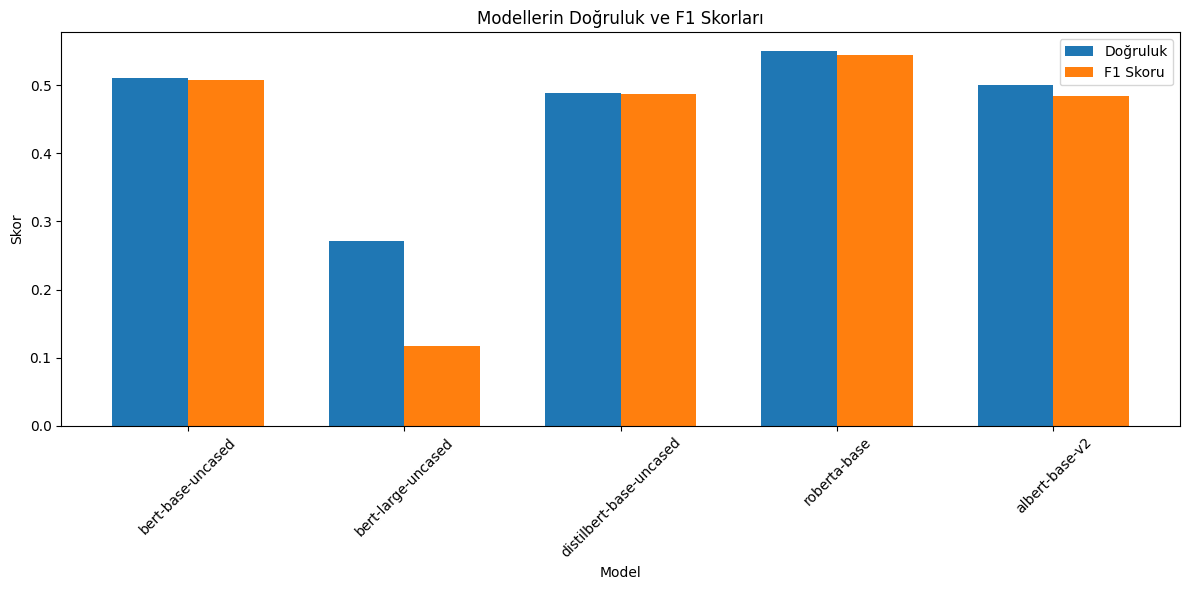

In [16]:
# Doğruluk ve F1 skorlarını görselleştir
plt.figure(figsize=(12, 6))

x = np.arange(len(results_df['Model']))
width = 0.35

plt.bar(x - width/2, results_df['Doğruluk'], width, label='Doğruluk')
plt.bar(x + width/2, results_df['F1 Skoru'], width, label='F1 Skoru')

plt.xlabel('Model')
plt.ylabel('Skor')
plt.title('Modellerin Doğruluk ve F1 Skorları')
plt.xticks(x, results_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

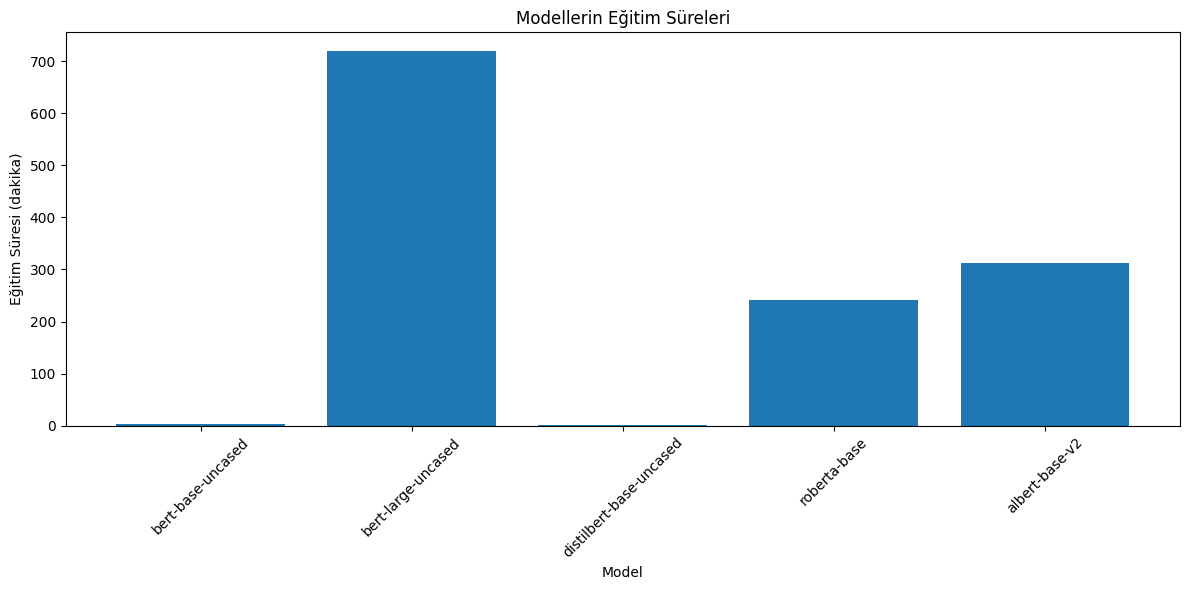

In [17]:
# Eğitim süresini görselleştir
plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['Eğitim Süresi (dk)'])
plt.xlabel('Model')
plt.ylabel('Eğitim Süresi (dakika)')
plt.title('Modellerin Eğitim Süreleri')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()